<a href="https://colab.research.google.com/github/Alihassan7726/Seq2Seq-learning-with-attension/blob/main/Machine_translation_with_attension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Spanish to English translation using Encoder & Decoder model with attension mechanism.**

## Steps inovolved :

1. Downlaoding and preparing DataSet .

2. Cleaning Text , adding <'START'> and <'END'> tokens . 

3. Creating word2idx and idx2word dictionaries .

4. Padding Sequences . 

5. Splitting Data .

6. Creating tf.keras DataSet . 

7. Creating Encoder_Class for encoder model and checking input/output shapes . 

8. Creating Attension_Class for alignment model and checking input/output shapes . 

9. Creating Decoder_Class for alignment model and checking input/output shapes . 
10. Defining optimizor , loss function model checkpoint . 

11. Defining training function and training loop . 

12. Function for inference and plotting results . 

13. Predictions .  


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## 1. Downloading and preparing DataSet .


In [ ]:
# Downloading the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

print(path_to_zip)

2646016/2638744 [==============================] - 0s 0us/step
/root/.keras/datasets/spa-eng.zip


In [ ]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [ ]:
# Opening file
with open(path_to_file , 'r' , encoding='utf-8') as f:
    lines = f.read().split('\n')
num_samples = 5
# reading 5 lines
for line in lines[: min(num_samples , len(lines)-1)]:
    input_text , target_text = line.split('\t')
input_text

'Hi.'

In [ ]:
line

'Hi.\tHola.'

## 2. Cleaning Text , adding <'START'> and <'END'> tokens . 


In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(text):
  return ''.join(c for c in unicodedata.normalize('NFD', text)
                 if unicodedata.category(c) != 'Mn')


def preprocess_sentence(text):
  sent = unicode_to_ascii(text.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1 ", sent)
  sent = re.sub(r'[" "]+', " ", sent)


  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sent = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sent)

  sent = sent.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  sent = '<start> ' + sent + ' <end>'
  return sent

In [ ]:
preprocess_sentence("I,am interested in games.")

'<start> i , am interested in games . <end>'

In [ ]:
pairs = [['<start> go . <end>', '<start> ve . <end>'], ['<start> go . <end>', '<start> vete . <end>'], ['<start> go . <end>', '<start> vaya . <end>'], ['<start> go . <end>', '<start> vayase . <end>'], ['<start> hi . <end>', '<start> hola . <end>']]
zip(pairs)

In [ ]:
for i in zip(*pairs):
  print(i)

('<start> go . <end>', '<start> go . <end>', '<start> go . <end>', '<start> go . <end>', '<start> hi . <end>')
('<start> ve . <end>', '<start> vete . <end>', '<start> vaya . <end>', '<start> vayase . <end>', '<start> hola . <end>')


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                for line in lines[:num_examples]]
  
  return zip(*word_pairs)

In [ ]:

en, sp = create_dataset(path_to_file, 5)
en

('<start> go . <end>',
 '<start> go . <end>',
 '<start> go . <end>',
 '<start> go . <end>',
 '<start> hi . <end>')

In [ ]:
# Below we can see very long sentences to be translated so seq2seq with attension is much better then basic one specially in this case.
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])


<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


## 3. Creating word2idx and idx2word dictionaries .


In [ ]:
# tokenizing and padding
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Limiting the size of data to just 50000 samples to be translated
num_examples = 50000
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer = load_dataset(path_to_file,
                                                                num_examples)

print(input_tensor.shape)
print(target_tensor.shape)

(50000, 16)
(50000, 12)


## 5. Splitting Data .


In [ ]:
max_length_targ , max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ)
print(max_length_inp)

# Splitting the data using a 90-10 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


12
16
45000 45000 5000 5000


In [ ]:
input_tensor_train[0]

array([ 1,  7, 40, 72, 33,  6,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [ ]:
# index to word mapping
def index_to_word(lang_tokenizer , tensor):
  for t in tensor:
    if t!=0:
      print(f'{t} -----> {lang_tokenizer.index_word[t]}')

In [ ]:
index_to_word(inp_lang_tokenizer , input_tensor_train[0])

1 -----> <start>
7 -----> no
40 -----> puedo
72 -----> ir
33 -----> con
6 -----> tom
3 -----> .
2 -----> <end>


In [ ]:

index_to_word(targ_lang_tokenizer , target_tensor_train[0])

1 -----> <start>
4 -----> i
25 -----> can
12 -----> t
64 -----> come
61 -----> with
7 -----> tom
3 -----> .
2 -----> <end>



## 6. Creating a tf.keras.dataset more specifically a generator object to save memory as well as computation power by providing slices/batch of data during execution so that only that small batch is loaded into memory at a particular time  

In [ ]:

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1 # Equivalent to num_encoder_tokens
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
print(len(dataset))

703


In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 12]))

In [ ]:
print("Input vocabulary size " , vocab_inp_size)
dataset.take(1)

Input vocabulary size  12999


<TakeDataset shapes: ((64, 16), (64, 12)), types: (tf.int32, tf.int32)>

In [ ]:
i = 0
for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    print(targ.shape)
    i+=1
print(i)

(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(64, 12)
(

In [ ]:
print(input_tensor_train.shape[1]) # Equivalent to max_source_lenght


16


### return_sequences=True , return_state=False :                          
return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step


### return_sequences=True , return_state=True :
return 3 arrays: stacked hidden states, last state_h, last state_c


### return_sequences=False, return_state=True :
return 3 arrays: state_h, state_h, state_c


### return_sequences=False, return_state=False :
returns the last hidden state state_h

## 7. Creating Encoder_Class for encoder model and checking input/output shapes . 


In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
arr = np.zeros(shape = (1,5))
arr

array([[0., 0., 0., 0., 0.]])

In [ ]:

tf.expand_dims(arr, 1)

<tf.Tensor: shape=(1, 1, 5), dtype=float64, numpy=array([[[0., 0., 0., 0., 0.]]])>

## 8. Creating Attension_Class for alignment model and checking input/output shapes . 


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


## 9. Creating Decoder_Class for alignment model and checking input/output shapes . 


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (64, 6817)


## 10. Defining optimizor , loss function , model checkpoint . 

In [ ]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [ ]:
tf.__version__

'2.4.1'

In [ ]:
tf.random.uniform((2*5, 1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.505347  ],
       [0.15939331],
       [0.07847762],
       [0.8046496 ],
       [0.71810555],
       [0.50567234],
       [0.2876259 ],
       [0.72645986],
       [0.81402516],
       [0.08972228]], dtype=float32)>

In [ ]:
tf.expand_dims([2]*5,1)

<tf.Tensor: shape=(5, 1), dtype=int32, numpy=
array([[2],
       [2],
       [2],
       [2],
       [2]], dtype=int32)>

## 11. Defining training function and training loop . 

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.7238
Epoch 1 Batch 100 Loss 2.2359
Epoch 1 Batch 200 Loss 1.9210
Epoch 1 Batch 300 Loss 1.9224
Epoch 1 Batch 400 Loss 1.6647
Epoch 1 Batch 500 Loss 1.6364
Epoch 1 Batch 600 Loss 1.4834
Epoch 1 Batch 700 Loss 1.3497
Epoch 1 Loss 1.8805
Time taken for 1 epoch 93.95 sec

Epoch 2 Batch 0 Loss 1.2303
Epoch 2 Batch 100 Loss 1.1513
Epoch 2 Batch 200 Loss 1.0473
Epoch 2 Batch 300 Loss 1.1273
Epoch 2 Batch 400 Loss 0.9585
Epoch 2 Batch 500 Loss 0.9079
Epoch 2 Batch 600 Loss 0.8674
Epoch 2 Batch 700 Loss 0.7378
Epoch 2 Loss 1.0362
Time taken for 1 epoch 81.19 sec

Epoch 3 Batch 0 Loss 0.6980
Epoch 3 Batch 100 Loss 0.6528
Epoch 3 Batch 200 Loss 0.5398
Epoch 3 Batch 300 Loss 0.4933
Epoch 3 Batch 400 Loss 0.5095
Epoch 3 Batch 500 Loss 0.6867
Epoch 3 Batch 600 Loss 0.5420
Epoch 3 Batch 700 Loss 0.5346
Epoch 3 Loss 0.6176
Time taken for 1 epoch 80.26 sec

Epoch 4 Batch 0 Loss 0.4154
Epoch 4 Batch 100 Loss 0.4405
Epoch 4 Batch 200 Loss 0.4677
Epoch 4 Batch 300 Loss 0.3657
Epoch 

## 12. Function for inference and plotting results . 


In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang_tokenizer.index_word[predicted_id] + ' '

    if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 13. Predictions . 

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


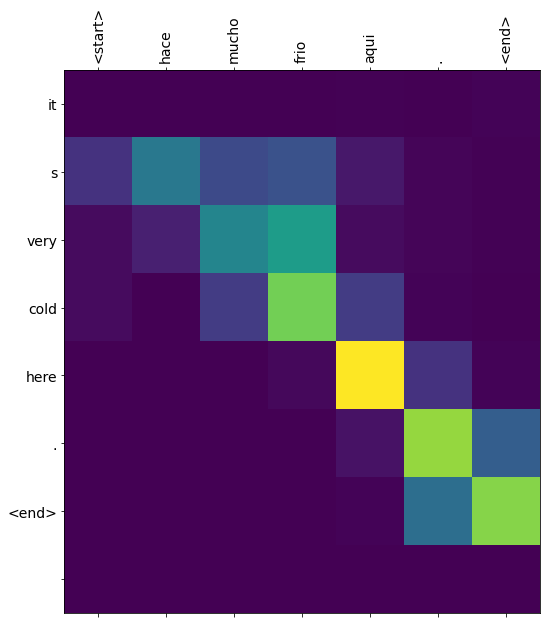

In [ ]:
translate(u'hace mucho frio aqui.')


Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


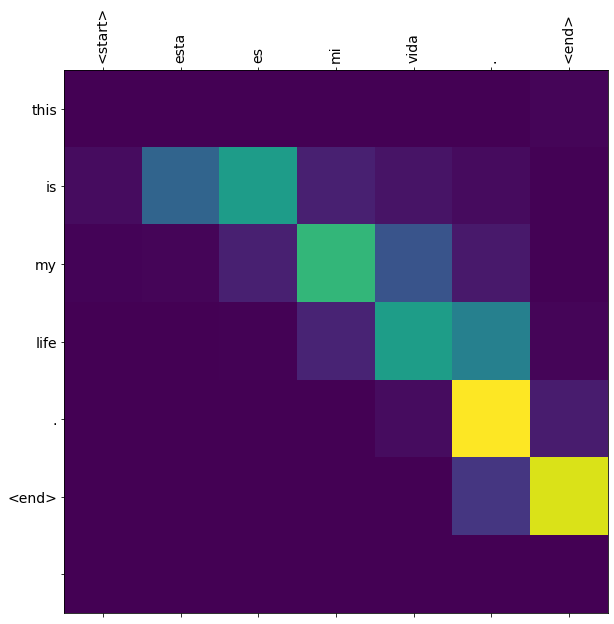

In [ ]:
translate(u'esta es mi vida.')


Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


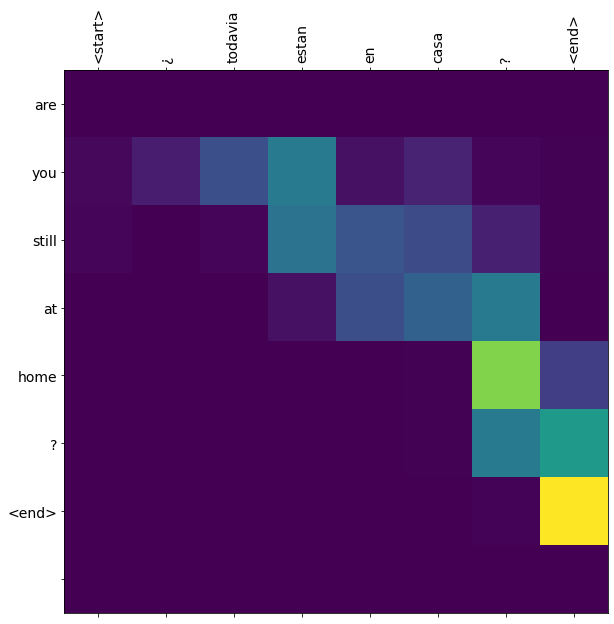

In [ ]:
translate(u'¿todavia estan en casa?')
